In [1]:
cluster = 'a2744'
zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}
nclus = {'a2744': "Abell 2744",
         'm0416' : "MACS 0416"}

zlens = zclus[cluster]
import sys
utils = 'C:\\Users\\Jackson\\Jupyter projects\\Master\\Utility\\'
sys.path.insert(0, utils)

root = 'C:\\Users\\Jackson\\Jupyter projects\\'
sys.path.insert(0, root)
filebase = 'C:\\Users\\Jackson\\Jupyter projects\\Master\\' + nclus[cluster] + "\\Files\\"

import numpy as np
import numpy.ma as ma
from astropy.cosmology import FlatLambdaCDM
from os import listdir
from os.path import isfile, join
import MCUtil as MC
import DeltaSquared as DS
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
import statistics
import fitClusParallel as myfit
import corner
import time

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


In [2]:
img = myfit.imgclass(root + "Files/" + cluster + '_images.dat',zlens,cosmo)

Read image data from file C:\Users\Jackson\Jupyter projects\Files/a2744_images.dat


In [3]:
reps = 3000

In [4]:
#Mass scatter only

gal = myfit.galclass(filebase + "Galaxy Probability Files\\CM + SigmaDet", logflags = [True, True])
gal.scale()
gal.draw(False)

defbase = gal.calcdef(img)[0]
defbase = defbase*np.reshape(img.Darr,(img.nimg,1))

print(defbase.shape)

Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + SigmaDet
(71, 2)


In [6]:
#get overall x, y means, and covariance matrix
def getDiffs(file):
    pdelta = []
    gal = myfit.galclass(file, logflags = [True, True])
    gal.scale()
    
    for i in range(reps):
        if i % 500 == 0:
            print("step {}".format(i))
        gal.draw(True)
        deftmp = gal.calcdef(img)[0]
        deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
        pdelta.append(deftmp - defbase)
        
    pdelta = np.array(pdelta)
    
    dx = np.reshape(pdelta[:,:,0] , (-1))
    dy = np.reshape(pdelta[:,:,1] , (-1))

    dtot = []
    dtot.append(dx)
    dtot.append(dy)
    dtot = np.array(dtot)

    mean = np.mean(dtot, axis = 1)
    cov = np.cov(dtot)
    return mean[0], mean[1], cov[0, 0], cov[1, 1], cov[0, 1]


In [7]:
#Get x y means and covariance for every model
probPath = filebase + "Galaxy Probability Files\\"
defFiles = [f for f in listdir(probPath) if isfile(join(probPath, f))]

allModels = {}

time0 = time.time()
for model in defFiles:
    allModels[model] = getDiffs(probPath + model)
    
time1 = time.time()
print(time1 - time0)

Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + box
step 0
step 500
step 1000
step 1500
step 2000
step 2500
Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + cnb
step 0
step 500
step 1000
step 1500
step 2000
step 2500
Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + gnb
step 0
step 500
step 1000
step 1500
step 2000
step 2500
Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + knn
step 0
step 500
step 1000
step 1500
step 2000
step 2500
Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + logistic
step 0
step 500
step 1000
step 1500
step 2000
step 2500
Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + mnb
s

In [9]:
np.save(filebase + "Deflection Stats", allModels)

In [11]:
x = np.load(filebase + "Deflection Stats.npy", allow_pickle = True)
allModels = x.item()

In [17]:
tot = np.zeros(5)

count = 0
for model in allModels.keys():
    if model == "CM + sigmaDet":
        continue
    tot += allModels[model]
    count += 1
    
avg = tot / count
print("Probabilistic models: ")
print(avg)

print("Fiducial model: ")
print(allModels["CM + sigmaDet"])

Probabilistic models: 
[ 0.32384297 -0.11665886  0.6845816   0.72166024 -0.0602726 ]
Fiducial model: 
(-0.0863841848212099, -0.15548240011945325, 0.5756512972352716, 0.6893712823616294, -0.060591548753513025)


Text(0.5, 0, 'Y Standard Deviation of Model')

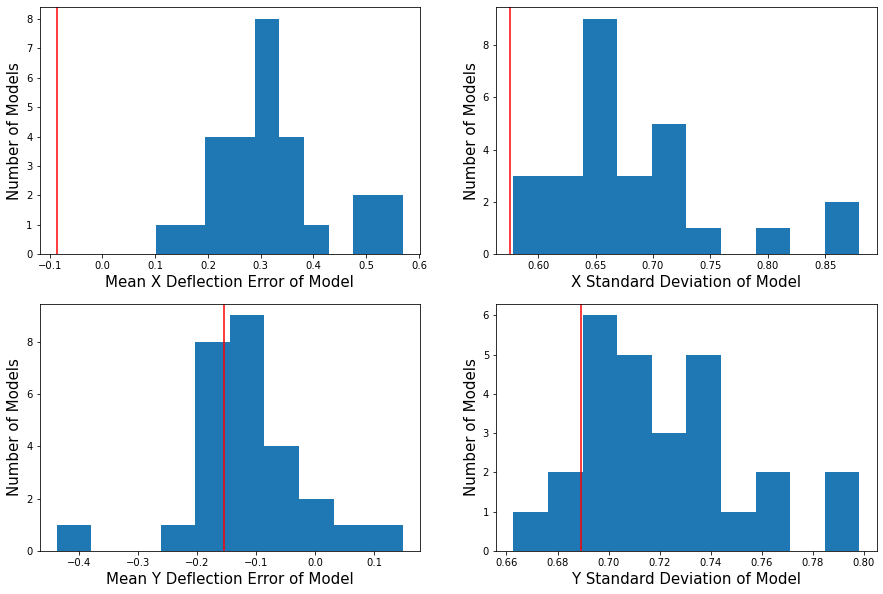

In [50]:
#Create histogram of x, y deflection means
xMeans = [allModels[model][0] for model in allModels.keys() if not model == "CM + sigmaDet"]
xSig = [allModels[model][2] for model in allModels.keys() if not model == "CM + sigmaDet"]

yMeans = [allModels[model][1] for model in allModels.keys() if not model == "CM + sigmaDet"]
ySig = [allModels[model][3] for model in allModels.keys() if not model == "CM + sigmaDet"]

fig, ax = plt.subplots(2, 2, figsize = (15, 10))
ax[0][0].hist(xMeans)
ax[0][0].axvline(allModels["CM + sigmaDet"][0], color = "red")
ax[0][0].set_ylabel("Number of Models", fontsize = 15)
ax[0][0].set_xlabel("Mean X Deflection Error of Model", fontsize = 15)

ax[0][1].hist(xSig)
ax[0][1].axvline(allModels["CM + sigmaDet"][2], color = "red")
ax[0][1].set_ylabel("Number of Models", fontsize = 15)
ax[0][1].set_xlabel("X Standard Deviation of Model", fontsize = 15)


ax[1][0].hist(yMeans)
ax[1][0].axvline(allModels["CM + sigmaDet"][1], color = "red")
ax[1][0].set_ylabel("Number of Models", fontsize = 15)
ax[1][0].set_xlabel("Mean Y Deflection Error of Model", fontsize = 15)

ax[1][1].hist(ySig)
ax[1][1].axvline(allModels["CM + sigmaDet"][3], color = "red")
ax[1][1].set_ylabel("Number of Models", fontsize = 15)
ax[1][1].set_xlabel("Y Standard Deviation of Model", fontsize = 15)

In [134]:
sum = 0
for key in allModels.keys():
    if key == "CM + sigmaDet":
        continue
    sum += allModels[key][2]

print(sum / 27)
print(allModels['CM + sigmaDet'])

0.6827339130434207
(-0.08189087425705166, -0.15032977084644905, 0.571351201816205, -0.06593100116006381)


Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + SigmaDet
Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + rnn
both: 
X mean: 0.21082410595959644
X std: 0.8123216709121154
Y mean: -0.14585330534216617
Y std: 0.8558536190457637
Mass scatter: 
X mean: -0.0823050856176234
X std: 0.7561654258735131
Y mean: -0.1406131976986219
Y std: 0.833480340990256


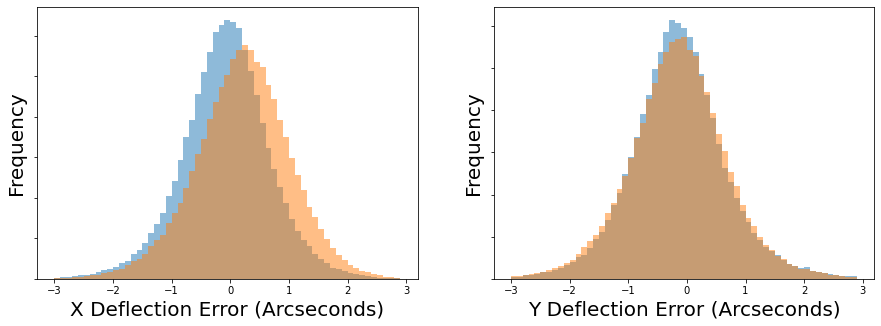

In [49]:
#get overall histograms
def plothist(file, ax):
    pdelta = []
    gal = myfit.galclass(file, logflags = [True, True])
    gal.scale()
    
    #print(gal.dat)
    
    for i in range(reps):
        gal.draw(True)
        deftmp = gal.calcdef(img)[0]
        deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
        
        #print(np.sum(gal.p[:,7]))

        pdelta.append(deftmp - defbase)
        
    pdelta = np.array(pdelta)
    pdeltax = np.reshape(pdelta[:,:,0], (-1))
    pdeltay = np.reshape(pdelta[:,:,1], (-1))

    ax[0].hist(mdeltax, bins = bins, alpha = 0.5)
    ax[0].hist(pdeltax, bins = bins, alpha = 0.5)
    
    
    ax[1].hist(mdeltay, bins = bins, alpha = 0.5)
    ax[1].hist(pdeltay, bins = bins, alpha = 0.5)
    
    print("both: ")
    print("X mean: " + str(np.mean(pdeltax)))
    print("X std: " + str(np.std(pdeltax)))
    print("Y mean: " + str(np.mean(pdeltay)))
    print("Y std: " + str(np.std(pdeltay)))

reps = 3000

gal = myfit.galclass(filebase + "Galaxy Probability Files\\CM + SigmaDet", logflags = [True, True])
gal.scale()
gal.draw(False)

defbase = gal.calcdef(img)[0]
defbase = defbase*np.reshape(img.Darr,(img.nimg,1))

mdelta = []

for i in range(reps):
    gal.draw(True)
    deftmp = gal.calcdef(img)[0]
    deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
    mdelta.append(deftmp - defbase)
    
mdelta = np.array(mdelta)

mdeltax = np.reshape(mdelta[:,:,0], (-1))
mdeltay = np.reshape(mdelta[:,:,1], (-1))
bins = np.arange(-3.0, 3.0, 0.1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


plothist(filebase + "Galaxy Probability Files\\CM + rnn", ax)

#ax2.set_title("R nearest neighbors y error")

ax[0].set_ylabel("Frequency", fontsize = 20)
ax[0].set_xlabel("X Deflection Error (Arcseconds)", fontsize = 20)
#ax.set_title("", fontsize = 20)
ax[0].yaxis.set_ticklabels([])

ax[1].set_ylabel("Frequency", fontsize = 20)
ax[1].set_xlabel("Y Deflection Error (Arcseconds)", fontsize = 20)
#ax.set_title("", fontsize = 20)
ax[1].yaxis.set_ticklabels([])

print("Mass scatter: ")
print("X mean: " + str(np.mean(mdeltax)))
print("X std: " + str(np.std(mdeltax)))
print("Y mean: " + str(np.mean(mdeltay)))
print("Y std: " + str(np.std(mdeltay)))

Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + SigmaDet
Read galaxy data from file C:\Users\Jackson\Jupyter projects\Master\Abell 2744\Files\Galaxy Probability Files\CM + rnn
both: 
X mean: 0.020761228831927134
X std: 0.0848881960884402
Y mean: -0.01159366847225045
Y std: 0.08554065972974272
Mass scatter: 
X mean: -0.008598404454833765
X std: 0.07533678625902834
Y mean: -0.015256447786829516
Y std: 0.08659265116091788


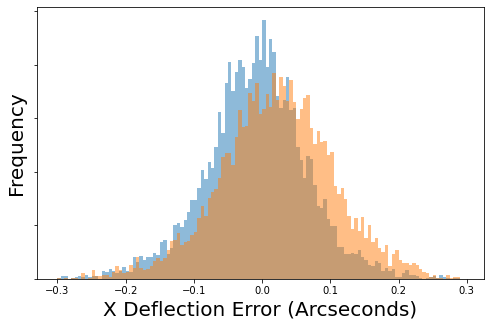

In [34]:
#get overall histograms
def plothist(file, ax):
    pdelta = []
    gal = myfit.galclass(file, logflags = [True, True])
    gal.scale(b0 = 0)
    
    #print(gal.dat)
    
    for i in range(reps):
        gal.draw(True)
        deftmp = gal.calcdef(img)[0]
        deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
        
        #print(np.sum(gal.p[:,7]))

        pdelta.append(deftmp - defbase)
        
    pdelta = np.array(pdelta)
    pdeltax = np.reshape(pdelta[:,:,0], (-1))
    pdeltay = np.reshape(pdelta[:,:,1], (-1))

    ax.hist(mdeltax, bins = bins, alpha = 0.5)
    ax.hist(pdeltax, bins = bins, alpha = 0.5)
    
    print("both: ")
    print("X mean: " + str(np.mean(pdeltax)))
    print("X std: " + str(np.std(pdeltax)))
    print("Y mean: " + str(np.mean(pdeltay)))
    print("Y std: " + str(np.std(pdeltay)))

reps = 100

gal = myfit.galclass(filebase + "Galaxy Probability Files\\CM + SigmaDet", logflags = [True, True])
gal.scale(b0 = 0)
gal.draw(False)

defbase = gal.calcdef(img)[0]
defbase = defbase*np.reshape(img.Darr,(img.nimg,1))

mdelta = []

for i in range(reps):
    gal.draw(True)
    deftmp = gal.calcdef(img)[0]
    deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
    mdelta.append(deftmp - defbase)
    
mdelta = np.array(mdelta)

mdeltax = np.reshape(mdelta[:,:,0], (-1))
mdeltay = np.reshape(mdelta[:,:,1], (-1))
bins = np.arange(-0.3, 0.3, 0.005)

fig, ax = plt.subplots(figsize=(8, 5))


plothist(filebase + "Galaxy Probability Files\\CM + rnn", ax)

#ax2.set_title("R nearest neighbors y error")

ax.set_ylabel("Frequency", fontsize = 20)
ax.set_xlabel("X Deflection Error (Arcseconds)", fontsize = 20)
#ax.set_title("", fontsize = 20)
ax.yaxis.set_ticklabels([])

print("Mass scatter: ")
print("X mean: " + str(np.mean(mdeltax)))
print("X std: " + str(np.std(mdeltax)))
print("Y mean: " + str(np.mean(mdeltay)))
print("Y std: " + str(np.std(mdeltay)))